# Linear fit DeepEnsemble

## The dataset: simple linefit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
## first, import all the necessary modules
import arviz as az
import corner
import graphviz
import jax
from jax import random
import jax.numpy as jnp # yes i know this is confusing
import matplotlib.pyplot as plt
import numpy as np

## in numpyro, you must specify number of sampling chains you will use upfront

# words of wisdom from Tian Li and crew:
# on gpu, don't use conda, use pip install
# HMC after SBI to look at degeneracies between params
# different guides (some are slower but better at showing degeneracies)

import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [3]:
import sys
sys.path.append('..')
from src.scripts import train, models, analysis

In [4]:
loss_type = 'var_loss'
# options are 'no_var_loss' or 'var_loss'
# var_loss is a gaussian negative log likelihood option that incorporates a variance term (for aleatoric uncertainty)

## Generate line data
Unlike in the case of inference, here we need to upfront generate a dataframe and replicate a bunch of columns. We will generate using random draws from distributions that are similar to the priors in the case of the likelihood-based inference analysis.

In [5]:
# same simulator as in likelihood-based inference,
# but here we have 
def simulator(thetas):
    m, b = thetas
    x_data = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    sigma = 10
    ε = rs.normal(loc=0, scale=sigma, size = len(x_data)) 
    return m * x_data + b + ε

def simulator_no_noise(thetas):
    m, b = thetas
    x_data = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    return m * x_data + b

In [6]:
x_data = np.linspace(0, 100, 101)

length_df = 1000
#ms = np.zeros((length_df, 101))
ms_list = []#np.zeros((length_df, 1))
bs_list = []#np.zeros((length_df, 1))
ys_list = []
#true_sigmas = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    m = rs.uniform(low=0, high=10)
    b = rs.uniform(low=-10, high=10)    
    ms_list.append(m)
    bs_list.append(b)
    '''
    xs[r,:] = thetas_1d[0]#np.linspace(0, 100, 101)
    ms[r,:] = thetas_1d[1]#np.repeat(thetas_1d[0], 101)
    bs[r,:] = thetas_1d[2]#np.repeat(thetas_1d[1], 101)
    sigmas[r,:] = thetas_1d[3]#np.repeat(thetas_1d[2], 101)
    '''
    ys_list.append(simulator([m,b]))
ms_array = np.repeat(ms_list, len(x_data))
bs_array = np.repeat(bs_list, len(x_data))
xs_array = np.tile(x_data, length_df)
ys_array = np.reshape(ys_list, (length_df * len(x_data)))

<Figure size 640x480 with 0 Axes>

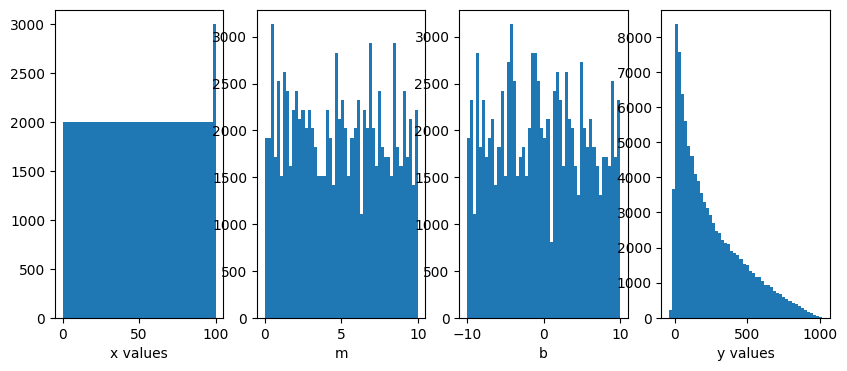

In [7]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(xs_array, bins=50)
ax0.set_xlabel('x values')
ax1 = fig.add_subplot(142)
ax1.hist(ms_array, bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(bs_array, bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(ys_array, bins=50)
ax3.set_xlabel('y values')
plt.show()

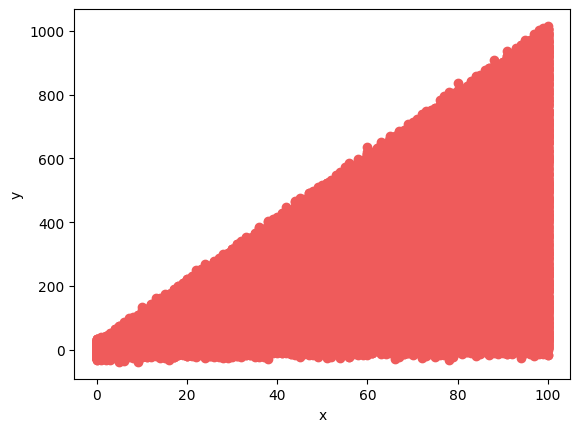

In [8]:
# visualize it before we normalize it
plt.scatter(xs_array, ys_array, color = '#EF5B5B')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [9]:
# combine all of the inputs into one array
# this will be fed into the neural network
inputs = np.array([xs_array, ms_array, bs_array]).T
print(np.shape(inputs))

(101000, 3)


In [10]:
# normalize everything before it goes into a network
inputmin = np.min(inputs, axis = 0)
inputmax = np.max(inputs, axis = 0)#, axis = 0)
outputmin = np.min(ys_array)
outputmax = np.max(ys_array)
print('input min, max', inputmin, inputmax, 'output min, max', outputmin, outputmax)

norm_inputs = (inputs - inputmin) / (inputmax - inputmin)
norm_outputs = (ys_array - outputmin) / (outputmax - outputmin)

input min, max [ 0.00000000e+00  4.79310705e-03 -9.99218548e+00] [100.           9.99959272   9.95910836] output min, max -38.39107900977657 1015.5557691311994


<Figure size 640x480 with 0 Axes>

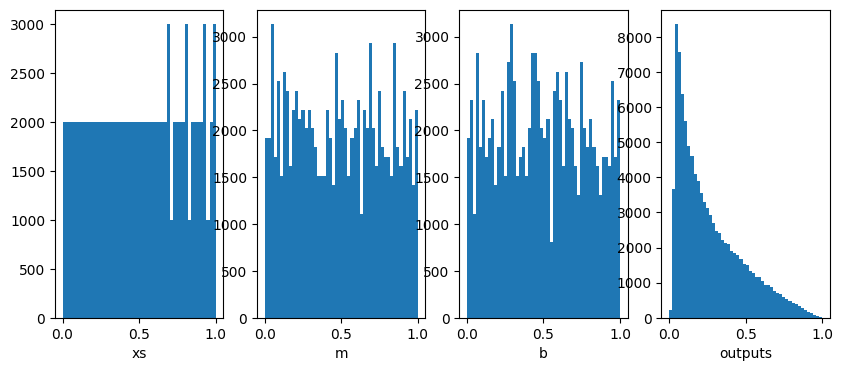

In [11]:
# now plot the histograms of the noramlized values
# to verify it worked
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(norm_inputs[:,0], bins=50)
ax0.set_xlabel('xs')
ax1 = fig.add_subplot(142)
ax1.hist(norm_inputs[:,1], bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(norm_inputs[:,2], bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(norm_outputs[:], bins=50)
ax3.set_xlabel('outputs')
plt.show()

In [12]:
# awesome, they are now normalized 0 - 1 but have the same distribution as before

(90900, 3) (90900,)
(3,)


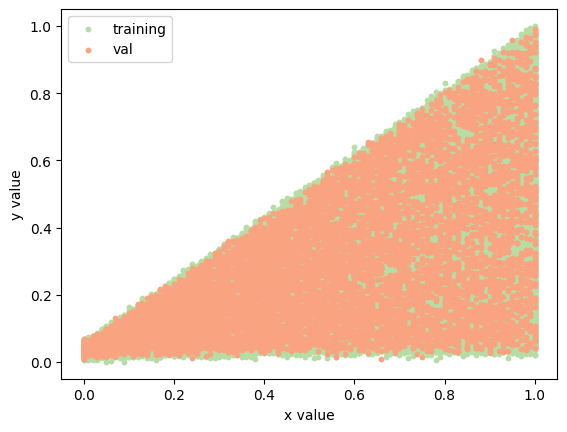

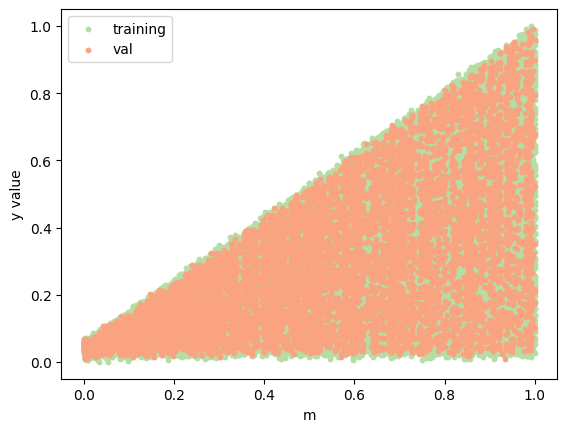

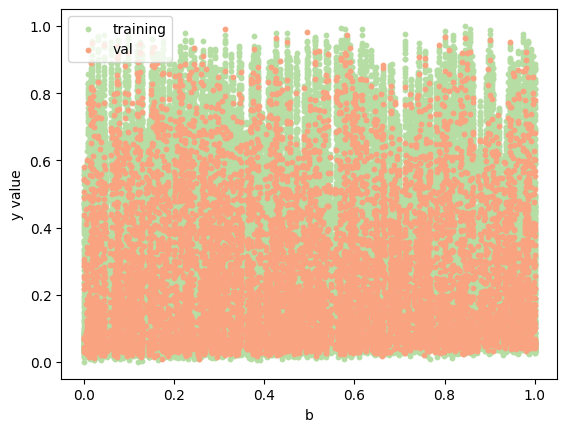

In [13]:
# prepare the training, validation, and test set split:
val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(norm_inputs, norm_outputs, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('m')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('b')
plt.ylabel('y value')
plt.show()

In [14]:
# okay now train the thing
BATCH_SIZE = 128

# add a dimension so that xs have a one channel input
#x_train = x_train.reshape(x_train.shape[0], 1) # 1 was the middle dimension
#x_val = x_val.reshape(x_val.shape[0], 1)

'''
print('y', np.shape(y_train))
print('x', np.shape(x_train))
STOP
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[1])
'''

trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (90900, 3)


In [41]:
# initialize the simple model
INIT_LR = 0.001
print("[INFO] initializing the gal model...")
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if loss_type == 'no_var_loss':
    model = models.de_no_var().to(device)
    # initialize our optimizer and loss function
    opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    lossFn = torch.nn.MSELoss(reduction="mean")
else:
    model = models.de_var().to(device)
    # initialize our optimizer and loss function
    opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    lossFn = torch.nn.GaussianNLLLoss(full=False, eps=1e-09, reduction="mean")#was full=False, default eps=1e-06
#nn.MSELoss(reduction = "mean")

[INFO] initializing the gal model...


In [42]:
print(model)

de_var(
  (ln_1): Linear(in_features=3, out_features=100, bias=True)
  (act1): ReLU()
  (drop1): Dropout(p=0.1, inplace=False)
  (ln_2): Linear(in_features=100, out_features=100, bias=True)
  (act2): ReLU()
  (drop2): Dropout(p=0.1, inplace=False)
  (ln_3): Linear(in_features=100, out_features=100, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.1, inplace=False)
  (ln_4): Linear(in_features=100, out_features=2, bias=True)
)


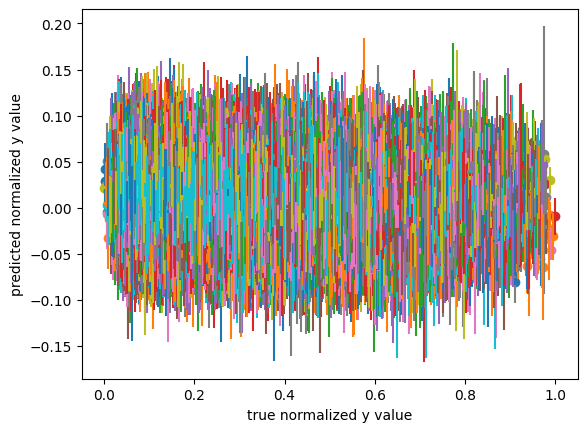

In [43]:
# plot what we're trying to predict
counter = 0
for (x, y) in trainDataLoader: # loading it up in batches
    #print('batch', counter, 'length', len(y))
    # send the input to the device
    (x, y) = (x.to(device), y.to(device))
    pred_tensor = model(x)
    pred = pred_tensor.detach().numpy()
    #print(y.shape, pred.shape)
    
    if loss_type == 'no_var_loss':
        print(np.shape(y), np.shape(pred))
        plt.scatter(y, pred, linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor, y)
        #print('loss', loss.item())
    else:
        plt.errorbar(y, pred[:,0], yerr = abs(pred[:,1]), linestyle='None')
        plt.scatter(y, pred[:,0], linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor[:,0], y, pred_tensor[:,1]**2)
        #print('loss', loss.item())
    
    counter += 1
plt.xlabel('true normalized y value')
plt.ylabel('predicted normalized y value')
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.show()
# Interesting, before the model is trained it basically predicts the mean?

[INFO] training the network...
saving checkpoints?
False
starting here 0
epoch 0 0.0


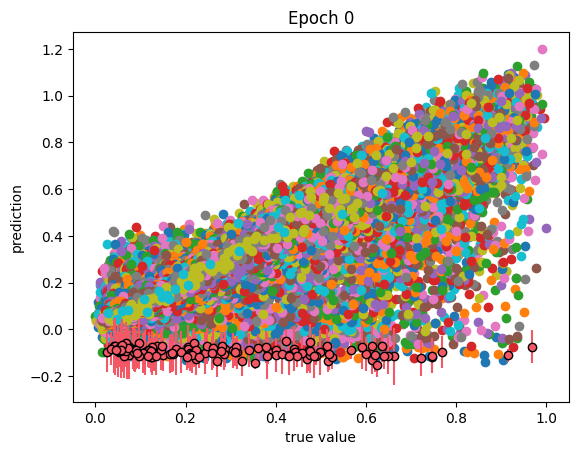

new best mse -2.9042556285858154 in epoch 0
epoch 1 0.05
new best mse -3.4106266498565674 in epoch 1
epoch 2 0.1
new best mse -3.524768829345703 in epoch 2
epoch 3 0.15
epoch 4 0.2
epoch 5 0.25


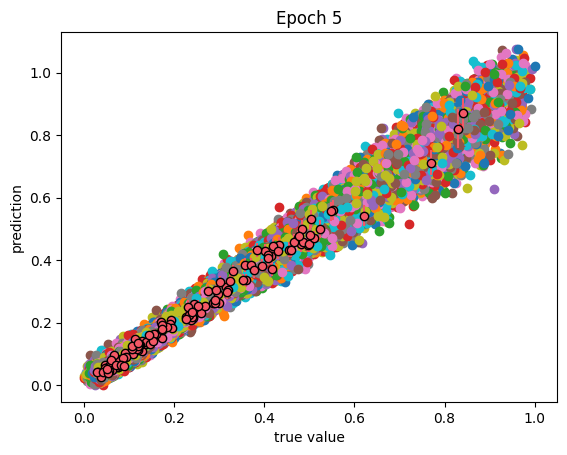

epoch 6 0.3
epoch 7 0.35
epoch 8 0.4
epoch 9 0.45
epoch 10 0.5


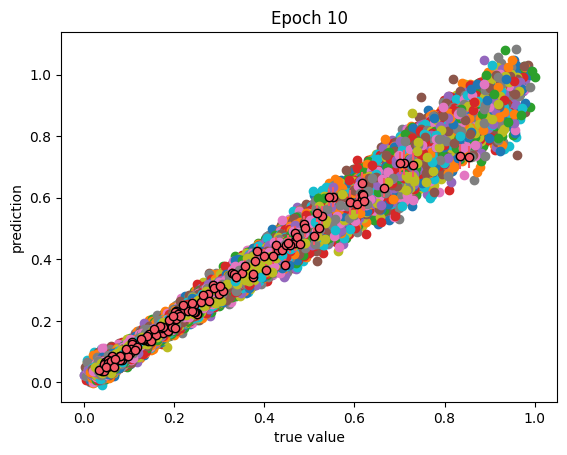

epoch 11 0.55
epoch 12 0.6
epoch 13 0.65
epoch 14 0.7
new best mse -3.6157467365264893 in epoch 14
epoch 15 0.75


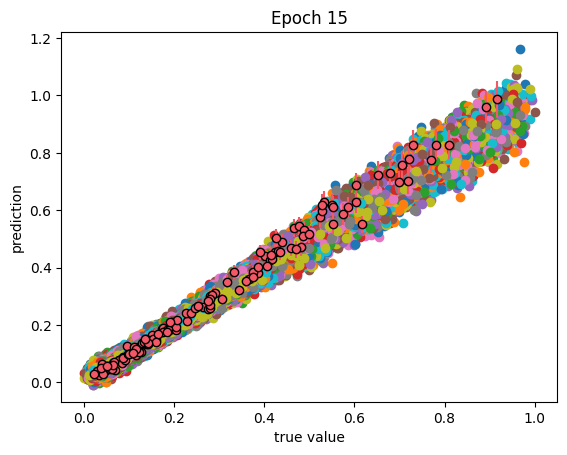

epoch 16 0.8
epoch 17 0.85


In [ ]:
n_models = 4
model_ensemble = train.train_DE(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             device,
             loss_type,
             n_models,
             model_name='DE',
             EPOCHS=20,
             save_checkpoints=False,
             plot=True)
 

## Test the model
To run it through it's paces, draw and one set of (m, b) values and run it through just one of the above trained models from the ensemble. This will work even if you only train one.

In [30]:
m_true = np.repeat(1, len(x_data))
b_true = np.repeat(5, len(x_data))


thetas_1d_true = np.array([x_data, m_true, b_true]).T
y_true = simulator([m_true[0], b_true[0]])
y_true_no_noise = simulator_no_noise([m_true[0], b_true[0]])
# now use the NN to make a prediction
model = model_ensemble[0]
model.eval()
# first, normalize the x value using the xmin and xmax before
'''
norm_inputs = (inputs - inputmin) / (inputmax - inputmin)
norm_outputs = (ys - outputmin) / (outputmax - outputmin)
'''
norm_thetas = (thetas_1d_true - inputmin) / (inputmax - inputmin)

y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
# now un-normalize this so you can plot it
if np.shape(y_norm_pred)[1] == 2:
    y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
    y_pred_sigma = abs((y_norm_pred[:,1]) * (outputmax - outputmin) + outputmin)
else:
    y_pred = (y_norm_pred) * (outputmax - outputmin) + outputmin
    y_pred_sigma = 0
    
    

In [31]:
print(np.shape(y_pred))
print(np.shape(y_norm_pred))

(101,)
(101, 2)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

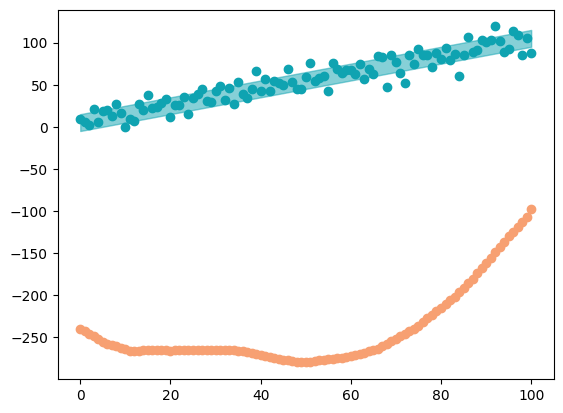

In [32]:
# plot
plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)
plt.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072')

if y_pred_sigma:
    
    plt.errorbar(x_data, y_pred, yerr = y_pred_sigma, label = 'NN prediction', color = '#F7A072')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
plt.show()


### Plot the ensemble of model predictions
This is the epistemic error. We can visualize this as individual model predictions and also as an error interval.

In [ ]:
color_list = ['#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360']

# first plot the true values
plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)


y_pred_list = []

for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
    # now un-normalize this so you can plot it
    if np.shape(y_norm_pred) == (2,):
        y_pred = (y_norm_pred[0]) * (outputmax - outputmin) + outputmin
        y_pred_sigma = abs((y_norm_pred[1]) * (outputmax - outputmin) + outputmin)
    else:
        y_pred = (y_norm_pred) * (outputmax - outputmin) + outputmin
        y_pred_sigma = 0
    plt.scatter(x_data, y_pred, label = f'NN prediction {m}', color = color_list[m])
    if y_pred_sigma:
        plt.errorbar(x_data, y_pred, yerr = y_pred_sigma, color = color_list[m])
    y_pred_list.append(np.reshape(y_pred, len(x_data)))

plt.legend()
plt.show()

print(np.shape(y_pred_list))
print(np.shape(np.mean(y_pred_list, axis = 0)))

plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)

plt.fill_between(x_data,
                 np.mean(y_pred_list, axis = 0) - np.std(y_pred_list, axis = 0),
                 np.mean(y_pred_list, axis = 0) + np.std(y_pred_list, axis = 0),
                 color = 'grey')
plt.show()
                 
                 


### Explore aleatoric error

In [ ]:
# plot the "posterior" plot, which is gonna be a Gaussian
# for each individual data point
print(np.shape(x_val), np.shape(y_val))
print(x_val[0], y_val[0])
# is there a way to convert x_val[0][3] back to its true value?
# og_value = normal_value * (xmax - xmin) + xmin
og_xval = x_val[0] * (xmax - xmin) + xmin
print('og_xval', og_xval)
og_yval = y_val[0] * (ymax - ymin) + ymin
print('og_yval', og_yval)
STOP
color_list = ['#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360']

for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val[0]))
    print(y_pred)
    STOP
    y_pred_list.append(y_pred[:,0].detach().numpy())
    

In [ ]:
# there's gotta be a good way to plot the x and the y
plt.clf()

color_list = ['#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360']
y_pred_list = []
for m in range(n_models):
    print(m)
    
        
    
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list.append(y_pred[:,0].detach().numpy())
    if m > 0:
        continue

    if loss_type == 'no_var_loss':
        plt.scatter(x_val[:,1], y_pred.detach().numpy(),
                label = 'predicted', s = 10, color = 'black')#color = color_list[m],
    else:
        plt.scatter(x_val[:,1], y_pred[:,0].detach().numpy(),
                label = f'predicted model {m}', color = 'black', ls = 'None')#color = color_list[m],
        plt.errorbar(x_val[:,1], y_pred[:,0].detach().numpy(),
                     yerr = abs(y_pred[:,1].detach().numpy()),
                label = f'predicted var model {m}', color = 'black', ls = 'None')#color = color_list[m],
    
dx_dtheta = analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], 0.1, time = 0.5, wrt = 'theta_0')
#print(dx_dtheta)
plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val, yerr = dx_dtheta, label = 'actual', color = 'red', ls = 'None')

plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

## Now epistemic error

In [ ]:
#print(y_pred_list)
#print(np.mean(y_pred_list, axis = 0))

plt.clf()
plt.scatter(x_val[:,1], np.mean(y_pred_list, axis = 0), label = 'predicted mean', color = 'black')
plt.errorbar(x_val[:,1], np.mean(y_pred_list, axis = 0),
             yerr = np.std(y_pred_list, axis = 0),
             label = 'predicted std', color = 'black',
             ls = 'None')
dx_dtheta = analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], 0.1, time = 0.5, wrt = 'theta_0')
#print(dx_dtheta)
plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val, yerr = dx_dtheta, label = 'actual analytic expectation', color = 'red', ls = 'None')
plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
plt.clf()
plt.scatter(x_val[:,3], np.mean(y_pred_list, axis = 0), label = 'predicted mean', color = 'black')
plt.errorbar(x_val[:,3], np.mean(y_pred_list, axis = 0),
             yerr = np.std(y_pred_list, axis = 0),
             label = 'predicted std', color = 'black',
             ls = 'None')
plt.scatter(x_val[:,3], y_val, label = 'actual', color = 'red', s = 10)
#plt.errorbar(x_val[:,3], y_val, yerr = dx_dtheta, label = 'actual analytic expectation', color = 'red', ls = 'None')
plt.xlabel('epsilon')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
# there's gotta be a good way to plot the x and the y
plt.clf()

y_pred_list_array = np.zeros((np.shape(x_val)[0], n_models))
for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list_array[:,m] = y_pred.detach().numpy().flatten()

sort_indices = np.argsort(x_val[:, 1])
x_val_sorted = x_val[sort_indices]
y_pred_list_sorted = y_pred_list_array[sort_indices]    
medians = np.median(y_pred_list_sorted, axis = 1).flatten()
mins = np.min(y_pred_list_sorted, axis = 1).flatten()
maxes = np.max(y_pred_list_sorted, axis = 1).flatten()

#plt.fill_between(x_val_sorted[:,1],
#                 mins,
#                 maxes,
#                 label = 'predicted')#color = color_list[m],
plt.errorbar(x_val_sorted[:,1], medians,
             yerr = [medians - mins,maxes - medians], linestyle = 'None', capsize = 5, color = 'black')

plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)

plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
# also go through and plot the error prop uncertainty given x_val
plt.clf()



y_pred_list_array = np.zeros((np.shape(x_val)[0], n_models))
for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list_array[:,m] = y_pred.detach().numpy().flatten()

sort_indices = np.argsort(x_val[:, 1])
x_val_sorted = x_val[sort_indices]
y_pred_list_sorted = y_pred_list_array[sort_indices]    
medians = np.median(y_pred_list_sorted, axis = 1).flatten()
mins = np.min(y_pred_list_sorted, axis = 1).flatten()
maxes = np.max(y_pred_list_sorted, axis = 1).flatten()

#plt.fill_between(x_val_sorted[:,1],
#                 mins,
#                 maxes,
#                 label = 'predicted')#color = color_list[m],
plt.errorbar(x_val_sorted[:,1], medians,
             yerr = [medians - mins,maxes - medians], linestyle = 'None', capsize = 5, color = 'black',
             label = 'prediction')

plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val,
             yerr = calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], percent_error * x_val[:,1], time = 0.5, wrt = 'theta_0'),
             color = 'red', ls = 'None', capsize = 5)


plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], percent_error * x_val[:,1], time = 0.5, wrt = 'theta_0')